# Betaflight System Identification

This notebook reads Betaflight blackbox logs (CSV format) and produces a JSON file of system identification parameters.

**Required CSV columns from blackbox log:**
- `time (us)` - timestamp in microseconds
- `gyroADC[0-2]` or `gyroUnfilt[0-2]` - gyro data (roll, pitch, yaw) in deg/s
- `accSmooth[0-2]` - accelerometer data (x, y, z) in g's
- `motor[0-3]` - motor outputs (normalized 0-1 or PWM values)

**Output:**
- JSON file with thrust coefficients, inertia, motor time constants, etc.

In [49]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

## Configuration

Edit these parameters to match your quadcopter:

In [50]:
# Model configuration
model_name = "my_quad"  # Name for output files

data_files = [
    '/home/miller/code/betaflight_tools/logs/sitl/blackbox_2.01.csv',  # Edit these paths to match your log files
]

# Physical parameters - MUST be measured/known for your quad
mass = 0.036  # kg - total mass of quadcopter
arm_length = 0.028  # meters - distance from center to motor

# Inertia ratio (Izz / average of Ixx and Iyy) - typical range 1.5-2.5 for X-frame quads
inertia_ratio = 1.8

# Motor output normalization
# Set to True if motor values are 0-1, False if they're PWM values (e.g., 1000-2000)
motors_normalized = False
motor_pwm_min = 1000  # Only used if motors_normalized = False
motor_pwm_max = 2000  # Only used if motors_normalized = False

# Accelerometer units - True if in g's, False if in m/s^2
accel_in_gs = True

# Gyro units - True if in deg/s, False if in rad/s
gyro_in_degs = True

# Thrust curve polynomial exponents to try
exponents_thrust_curve = [[0, 1, 2], [2]]  # Try quadratic with offset, and pure quadratic

# Debug/output settings
dpi = 150
debug = False

In [51]:
# Build quadcopter model geometry
# Standard Betaflight motor layout (X configuration):
# Motor 1: Front Right (CW)
# Motor 2: Rear Right (CCW) 
# Motor 3: Rear Left (CW)
# Motor 4: Front Left (CCW)

rotor_x = arm_length * np.cos(np.pi/4)  # 45 degree arms
rotor_y = arm_length * np.sin(np.pi/4)

model = {
    "gravity": 9.81,
    "mass": mass,
    "rotor_positions": np.array([
        [ rotor_x, -rotor_y, 0],  # Motor 1: Front Right
        [-rotor_x, -rotor_y, 0],  # Motor 2: Rear Right
        [-rotor_x,  rotor_y, 0],  # Motor 3: Rear Left
        [ rotor_x,  rotor_y, 0]   # Motor 4: Front Left
    ]),
    "rotor_thrust_directions": np.array([
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]
    ]),
    "rotor_torque_directions": np.array([
        [0, 0, -1],  # Motor 1: CW (negative torque)
        [0, 0,  1],  # Motor 2: CCW (positive torque)
        [0, 0, -1],  # Motor 3: CW (negative torque)
        [0, 0,  1]   # Motor 4: CCW (positive torque)
    ])
}

g = np.array([0, 0, -model["gravity"]])

## Step 0: Load Betaflight Blackbox CSV Data

In [52]:
# List your blackbox CSV files here
# These should be exported from Betaflight Blackbox Explorer

def load_betaflight_csv(filepath):
    """Load a Betaflight blackbox CSV file and convert to standard format."""
    df = pd.read_csv(filepath, sep=', ')
    
    flight = {
        "name": filepath,
        "convention": "frd",  # Betaflight uses FRD (Front-Right-Down)
        "data": {}
    }
    
    # Get timestamps - convert from microseconds to seconds
    if 'time (us)' in df.columns:
        timestamps = np.array(df['time (us)']) * 1e-6
    elif 'time' in df.columns:
        timestamps = np.array(df['time'])
    else:
        raise ValueError(f"No time column found in {filepath}")
    
    # Load accelerometer data
    accel_scale = 9.81 if accel_in_gs else 1.0
    accel_cols = ['accSmooth[0]', 'accSmooth[1]', 'accSmooth[2]']
    if all(col in df.columns for col in accel_cols):
        flight["data"]["vehicle_acceleration_xyz[0]"] = {
            "timestamps": timestamps, 
            "values": np.array(df['accSmooth[0]']) * accel_scale
        }
        flight["data"]["vehicle_acceleration_xyz[1]"] = {
            "timestamps": timestamps, 
            "values": np.array(df['accSmooth[1]']) * accel_scale
        }
        flight["data"]["vehicle_acceleration_xyz[2]"] = {
            "timestamps": timestamps, 
            "values": np.array(df['accSmooth[2]']) * accel_scale
        }
    else:
        raise ValueError(f"Accelerometer columns not found in {filepath}")
    
    # Load gyro data - prefer filtered (gyroADC) over unfiltered
    gyro_scale = np.pi/180 if gyro_in_degs else 1.0  # Convert to rad/s
    gyro_cols = ['gyroADC[0]', 'gyroADC[1]', 'gyroADC[2]']
    gyro_unfilt_cols = ['gyroUnfilt[0]', 'gyroUnfilt[1]', 'gyroUnfilt[2]']
    
    if all(col in df.columns for col in gyro_cols):
        gyro_source = gyro_cols
    elif all(col in df.columns for col in gyro_unfilt_cols):
        gyro_source = gyro_unfilt_cols
    else:
        raise ValueError(f"Gyro columns not found in {filepath}")
    
    flight["data"]["vehicle_angular_velocity_xyz[0]"] = {
        "timestamps": timestamps, 
        "values": np.array(df[gyro_source[0]]) * gyro_scale
    }
    flight["data"]["vehicle_angular_velocity_xyz[1]"] = {
        "timestamps": timestamps, 
        "values": np.array(df[gyro_source[1]]) * gyro_scale
    }
    flight["data"]["vehicle_angular_velocity_xyz[2]"] = {
        "timestamps": timestamps, 
        "values": np.array(df[gyro_source[2]]) * gyro_scale
    }
    
    # Load motor outputs
    motor_cols = ['motor[0]', 'motor[1]', 'motor[2]', 'motor[3]']
    if all(col in df.columns for col in motor_cols):
        for i, col in enumerate(motor_cols):
            motor_values = np.array(df[col])
            # Normalize to 0-1 if needed
            if not motors_normalized:
                motor_values = (motor_values - motor_pwm_min) / (motor_pwm_max - motor_pwm_min)
                motor_values = np.clip(motor_values, 0, 1)
            flight["data"][f"motor_control[{i}]"] = {
                "timestamps": timestamps,
                "values": motor_values
            }
    else:
        raise ValueError(f"Motor columns not found in {filepath}")
    
    return flight

# Load all flight data
flights = []
for data_file in data_files:
    try:
        flight = load_betaflight_csv(data_file)
        flights.append(flight)
        print(f"Loaded {data_file}: {len(flight['data']['vehicle_acceleration_xyz[0]']['timestamps'])} samples")
    except Exception as e:
        print(f"Error loading {data_file}: {e}")

print(f"\nLoaded {len(flights)} flight(s)")

/tmp/ipykernel_5763/1197153139.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(filepath, sep=', ')


Loaded /home/miller/code/betaflight_tools/logs/sitl/blackbox_2.01.csv: 95195 samples

Loaded 1 flight(s)


## Step 1: Plot the Flights

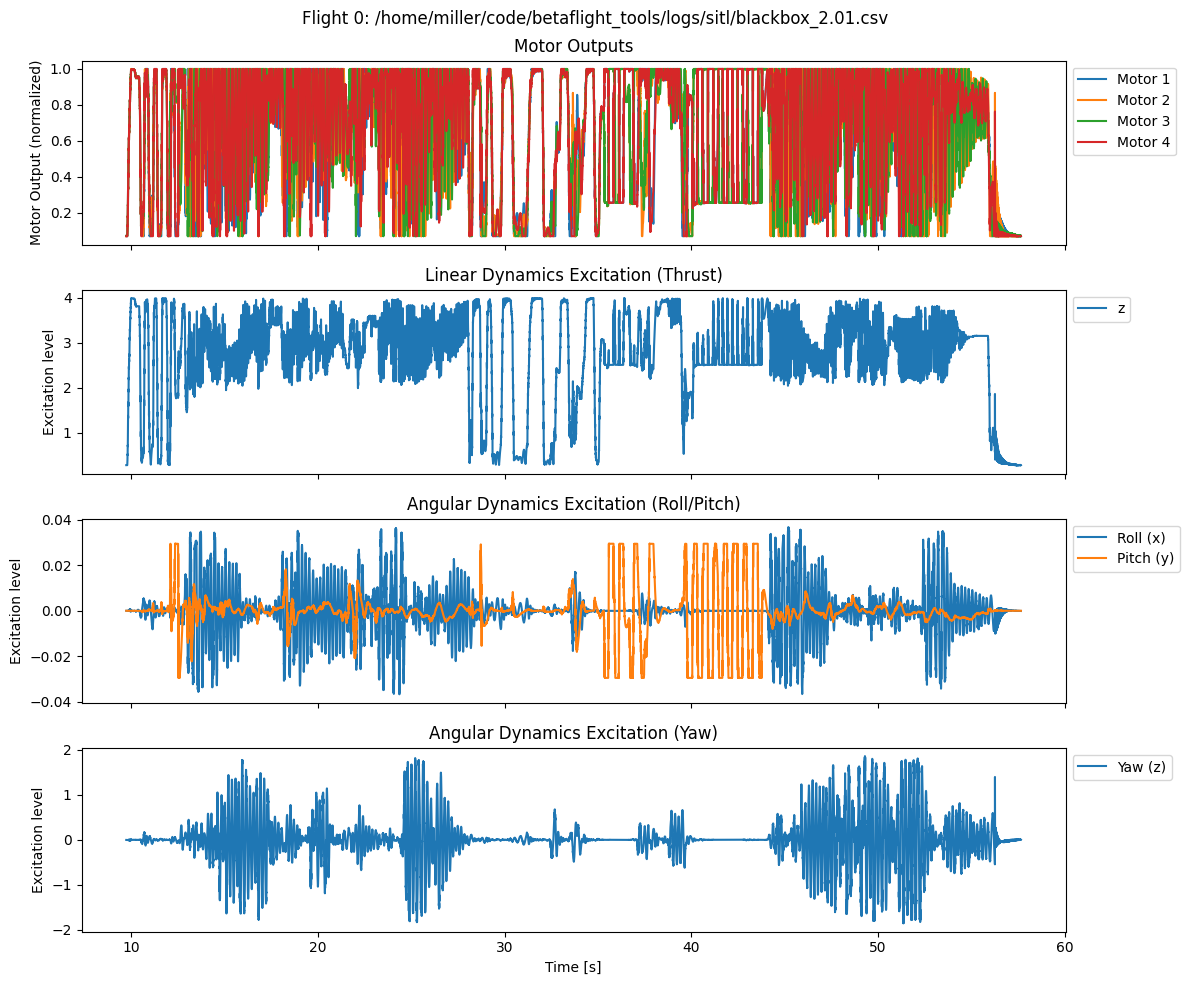

In [53]:
output_topic = "motor"

for flight_i, flight in enumerate(flights):
    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    ax = 0
    for motor_i in range(4):
        key = f"motor_control[{motor_i}]"
        axs[ax].plot(flight["data"][key]["timestamps"], flight["data"][key]["values"], label=f"Motor {motor_i+1}")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Motor Output (normalized)')
    axs[ax].set_title('Motor Outputs')
    ax += 1
    
    # Calculate thrust and torque excitation
    thrust_values = []
    thrust_torque_values = []
    geometric_torque_values = []
    timestamps = flight["data"]["motor_control[0]"]["timestamps"]
    
    for motor_i in range(4):
        key = f"motor_control[{motor_i}]"
        motor_vals = flight["data"][key]["values"]
        thrust_values.append(motor_vals[:, np.newaxis] * model["rotor_thrust_directions"][motor_i][np.newaxis, :])
        thrust_torque_values.append(motor_vals[:, np.newaxis] * model["rotor_torque_directions"][motor_i][np.newaxis, :])
        geometric_torque_values.append(motor_vals[:, np.newaxis] * np.cross(model["rotor_positions"][motor_i], model["rotor_thrust_directions"][motor_i])[np.newaxis, :])
    
    thrust_values = sum(thrust_values)
    thrust_torque_values = sum(thrust_torque_values)
    geometric_torque_values = sum(geometric_torque_values)

    axs[ax].set_title("Linear Dynamics Excitation (Thrust)")
    axs[ax].plot(timestamps, thrust_values[:, 2], label="z")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Excitation level')
    ax += 1
    
    axs[ax].set_title("Angular Dynamics Excitation (Roll/Pitch)")
    axs[ax].plot(timestamps, geometric_torque_values[:, 0], label="Roll (x)")
    axs[ax].plot(timestamps, geometric_torque_values[:, 1], label="Pitch (y)")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Excitation level')
    ax += 1
    
    axs[ax].set_title("Angular Dynamics Excitation (Yaw)")
    axs[ax].plot(timestamps, thrust_torque_values[:, 2], label="Yaw (z)")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Excitation level')

    axs[-1].set_xlabel('Time [s]')
    fig.suptitle(f"Flight {flight_i}: {flight['name']}")
    plt.tight_layout()
    os.makedirs("figures", exist_ok=True)
    plt.savefig(f"figures/{model_name}_flight{flight_i}.png", dpi=dpi)
    plt.show()

## Step 2: Select Time Slices for System Identification

Select time ranges with good excitation for each identification task:
- **Thrust**: Vertical motion with varying throttle
- **Roll/Pitch Inertia**: Roll/pitch maneuvers 
- **Yaw Inertia**: Yaw maneuvers

In [54]:
# Edit these time ranges based on your flight data
# Look at the plots above to identify good excitation regions

timeframes_thrust = [
    {
        "flight": 0,
        "start": 5,  # seconds
        "end": 55
    }
]

timeframes_inertia_roll_pitch = [
    {
        "flight": 0,
        "start": 5,
        "end": 55
    }
]

timeframes_inertia_yaw = [
    {
        "flight": 0,
        "start": 5,
        "end": 55
    }
]

In [55]:
def extract_timeframes(flights, timeframes):
    """Extract time slices from flights."""
    output_flights = []
    fragment_counter = {}
    for timeframe in timeframes:
        flight = deepcopy(flights[timeframe["flight"]])
        fragment_id = fragment_counter.get(flight["name"], 0)
        fragment_counter[flight["name"]] = fragment_id + 1
        flight["name"] = flight["name"] + f".{fragment_id}"
        start, end = timeframe["start"], timeframe["end"]
        data = flight["data"]
        for series in data:
            mask = (data[series]["timestamps"] > start) & (data[series]["timestamps"] < end)
            data[series]["timestamps"] = data[series]["timestamps"][mask]
            data[series]["values"] = data[series]["values"][mask]
        output_flights.append(flight)
    return output_flights

flights_thrust = extract_timeframes(flights, timeframes_thrust)
flights_inertia_roll_pitch = extract_timeframes(flights, timeframes_inertia_roll_pitch)
flights_inertia_yaw = extract_timeframes(flights, timeframes_inertia_yaw)

print(f"Thrust timeframes: {len(flights_thrust)} segments")
print(f"Roll/Pitch inertia timeframes: {len(flights_inertia_roll_pitch)} segments")
print(f"Yaw inertia timeframes: {len(flights_inertia_yaw)} segments")

Thrust timeframes: 1 segments
Roll/Pitch inertia timeframes: 1 segments
Yaw inertia timeframes: 1 segments


## Step 3: Detect Gaps and Interpolate Data

In [56]:
def slice_gaps_and_interpolate(flights):
    """Handle gaps in data and interpolate to common timestamps."""
    flights_output = []
    for flight in flights:
        lowest_frequency = None
        lowest_frequency_name = None
        highest_frequency = None
        highest_frequency_name = None
        
        for name, data in flight["data"].items():
            diff = np.diff(data["timestamps"])
            if len(diff) == 0:
                continue
            frequency = 1/np.median(diff)
            if lowest_frequency is None or frequency < lowest_frequency:
                lowest_frequency = frequency
                lowest_frequency_name = name
            if highest_frequency is None or frequency > highest_frequency:
                highest_frequency = frequency
                highest_frequency_name = name

        if lowest_frequency is None:
            print(f"Skipping flight with no valid data")
            continue
            
        interval_threshold = 3 * 1/lowest_frequency
        print(f"Lowest frequency: {lowest_frequency:.1f} Hz for {lowest_frequency_name}")
        print(f"Highest frequency: {highest_frequency:.1f} Hz for {highest_frequency_name}")

        earliest_timestamp_all = max([data["timestamps"][0] for name, data in flight["data"].items() if len(data["timestamps"]) > 0])
        latest_timestamp_all = min([data["timestamps"][-1] for name, data in flight["data"].items() if len(data["timestamps"]) > 0])
        
        master_timestamps_full = flight["data"][highest_frequency_name]["timestamps"]
        master_timestamps = master_timestamps_full[(master_timestamps_full > earliest_timestamp_all) & (master_timestamps_full < latest_timestamp_all)]
        
        if len(master_timestamps) == 0:
            print(f"Skipping flight with no overlapping timestamps")
            continue
            
        earliest_timestamp = master_timestamps[0]
        latest_timestamp = master_timestamps[-1]
        total_time = latest_timestamp - earliest_timestamp

        # Find gaps
        gaps = []
        for name, data in flight["data"].items():
            current_timestamps_full = data["timestamps"]
            current_timestamps = current_timestamps_full[(current_timestamps_full > earliest_timestamp) & (current_timestamps_full < latest_timestamp)]
            current_timestamps_augmented = np.concatenate([[earliest_timestamp], current_timestamps, [latest_timestamp]])
            diff = np.diff(current_timestamps_augmented)
            current_gaps = np.where(diff > interval_threshold)[0]
            for gap in current_gaps:
                if gap < len(data["timestamps"]) - 1:
                    gap_start = data["timestamps"][gap]
                    gap_end = data["timestamps"][gap+1]
                    gaps.append((gap_start, gap_end))
        
        gaps_sorted = sorted(gaps, key=lambda x: x[0])

        # Combine overlapping gaps
        combined_gaps = []
        current_gap_start = None
        current_gap_end = None

        for i, (gap_start, gap_end) in enumerate(gaps_sorted):
            if current_gap_start is None:
                current_gap_start = gap_start
                current_gap_end = gap_end
            elif gap_start <= current_gap_end + interval_threshold:
                current_gap_end = max(current_gap_end, gap_end)
            else:
                combined_gaps.append((current_gap_start, current_gap_end))
                current_gap_start = gap_start
                current_gap_end = gap_end
        
        if current_gap_start is not None:
            combined_gaps.append((current_gap_start, current_gap_end))

        print(f"Number of gaps: {len(combined_gaps)}")
        
        total_gap_time = sum([gap_end - gap_start for gap_start, gap_end in combined_gaps])
        if total_gap_time >= 0.1 * total_time:
            print(f"Warning: Total gap time {total_gap_time:.2f}s is >= 10% of total time")

        # Create subflights from continuous segments
        subflights = []
        current_segment_start_timestamp = earliest_timestamp
        for gap_start, gap_end in [*combined_gaps, (latest_timestamp, latest_timestamp)]:
            segment_time = gap_start - current_segment_start_timestamp
            if segment_time > 0.01 * total_time:
                current_segment_timestamps = master_timestamps[(master_timestamps > current_segment_start_timestamp) & (master_timestamps < gap_start)]
                sub_flight = {
                    name: {
                        "timestamps": current_segment_timestamps,
                        "values": np.interp(current_segment_timestamps, data["timestamps"], data["values"])
                    } for name, data in flight["data"].items()
                }
                subflights.append(sub_flight)
            current_segment_start_timestamp = gap_end
        
        print(f"Number of subflights: {len(subflights)}")

        for subflight_i, subflight in enumerate(subflights):
            flights_output.append({
                "name": flight["name"] + f"_{subflight_i}",
                "convention": flight["convention"],
                "timestamps": subflight[highest_frequency_name]["timestamps"],
                "data": subflight
            })
    return flights_output

In [57]:
print("Processing thrust data...")
sliced_and_interpolated_flights_thrust = slice_gaps_and_interpolate(flights_thrust)
print("\nProcessing roll/pitch inertia data...")
sliced_and_interpolated_flights_inertia_roll_pitch = slice_gaps_and_interpolate(flights_inertia_roll_pitch)
print("\nProcessing yaw inertia data...")
sliced_and_interpolated_flights_inertia_yaw = slice_gaps_and_interpolate(flights_inertia_yaw)

Processing thrust data...
Lowest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Highest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Number of gaps: 104
Number of subflights: 32

Processing roll/pitch inertia data...
Lowest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Highest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Number of gaps: 104
Number of subflights: 32

Processing yaw inertia data...
Lowest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Highest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Number of gaps: 104
Number of subflights: 32


## Step 4: Apply Motor Delay Filter and Combine Data

In [58]:
def filter_ema(timestamps, values, T_m):
    """Apply exponential moving average filter to model motor delay."""
    filtered = []
    current = None
    previous_t = None
    for t, value in zip(timestamps, values):
        if current is None:
            current = value
        else:
            delta_t = t - previous_t
            alpha = np.exp(-delta_t / T_m)
            current = alpha * current + (1 - alpha) * value
        filtered.append(current)
        previous_t = t
    return np.array(filtered)

def combine(flights, T_m, thrust_curves=None):
    """Combine flight data with motor delay filtering."""
    def FRD2FLU(x):
        return np.array([x[0], -x[1], -x[2]])

    for flight in flights:
        timestamps = flight["timestamps"]
        frd = flight["convention"] == "frd"
        
        # Get motor setpoints
        motor_setpoints = np.array([flight["data"][f"motor_control[{i}]"]["values"] for i in range(4)]).T

        # Get acceleration and convert frame if needed
        acceleration_original = np.array([flight["data"][f"vehicle_acceleration_xyz[{i}]"]["values"] for i in range(3)]).T
        acceleration = np.array(list(map(FRD2FLU, acceleration_original))) if frd else acceleration_original
        
        # Get angular velocity and convert frame if needed
        omega_original = np.array([flight["data"][f"vehicle_angular_velocity_xyz[{i}]"]["values"] for i in range(3)]).T
        omega = np.array(list(map(FRD2FLU, omega_original))) if frd else omega_original
        
        # Compute angular acceleration from gyro data
        domega = np.gradient(omega, timestamps, axis=0)
        
        flight["motor_setpoints"] = motor_setpoints
        flight["motors"] = filter_ema(timestamps, motor_setpoints, T_m)
        flight["acceleration"] = acceleration
        flight["omega"] = omega
        flight["domega"] = domega
        
        if thrust_curves is not None:
            def apply_thrust_curves(motors, thrust_curves):
                thrusts = []
                for thrust_curve, motor in zip(thrust_curves, motors):
                    thrust = sum(coeff * motor**exp for exp, coeff in enumerate(thrust_curve))
                    thrusts.append(thrust)
                return np.array(thrusts)
            
            flight["thrusts"] = np.array([apply_thrust_curves(motors, thrust_curves) for motors in flight["motors"]])
            motor_thrust_to_torque_geometric = np.array([np.cross(model["rotor_positions"][motor_i], model["rotor_thrust_directions"][motor_i]) for motor_i in range(4)])
            flight["pre_torque"] = flight["thrusts"][:, :, np.newaxis] * model["rotor_torque_directions"]
            flight["pre_torque_geometric"] = flight["thrusts"][:, :, np.newaxis] * motor_thrust_to_torque_geometric
    
    thrusts_combined = {}
    if thrust_curves is not None:
        thrusts_combined = {
            "thrusts": np.concatenate([flight["thrusts"] for flight in flights]),
            "pre_torque": np.concatenate([flight["pre_torque"] for flight in flights]),
            "pre_torque_geometric": np.concatenate([flight["pre_torque_geometric"] for flight in flights]),
        }

    return {
        "motor_setpoints": np.concatenate([flight["motor_setpoints"] for flight in flights]),
        "motors": np.concatenate([flight["motors"] for flight in flights]),
        "acceleration": np.concatenate([flight["acceleration"] for flight in flights]),
        "omega": np.concatenate([flight["omega"] for flight in flights]),
        "domega": np.concatenate([flight["domega"] for flight in flights]),
        **thrusts_combined
    }, flights

In [59]:
# Test with initial motor time constant
T_m_test = 0.05
combined_test, _ = combine(sliced_and_interpolated_flights_thrust, T_m_test)
print(f"Combined data shape: {combined_test['acceleration'].shape}")

Combined data shape: (68555, 3)


## Step 5: Estimate Motor Parameters

In [60]:
def estimate_motor_parameters(combined, model, exponents, verbose=True, separate=True):
    """Estimate thrust curve coefficients using least squares."""
    b = []
    A = []
    num_steps = len(combined["motors"])
    
    for step_i in range(num_steps):
        acceleration = combined["acceleration"][step_i]
        b.append(model["mass"] * acceleration)
        current_A = []
        motor = combined["motors"][step_i]
        
        if separate:
            for motor_i in range(4):
                for exponent in exponents:
                    current_A.append(model["rotor_thrust_directions"][motor_i] * motor[motor_i] ** exponent)
        else:
            for exponent in exponents:
                acc = np.zeros(3)
                for motor_i in range(4):
                    acc += model["rotor_thrust_directions"][motor_i] * motor[motor_i] ** exponent
                current_A.append(acc)
        A.append(np.array(current_A).T)

    A = np.array(A).reshape(-1, (4 if separate else 1) * len(exponents))
    b = np.array(b).reshape(-1)
    
    if verbose:
        print(f"A shape: {A.shape}")
        print(f"b shape: {b.shape}")
    
    K_f = np.linalg.lstsq(A, b, rcond=None)[0].reshape(-1, len(exponents))
    rmse = np.sqrt(np.mean((A @ K_f.reshape(-1) - b) ** 2))
    
    if separate:
        K_f_full = np.array([[K_f[motor_i][exponents.index(i)] if i in exponents else 0 for i in range(3)] for motor_i in range(4)])
    else:
        K_f_full = np.array([[K_f[0][exponents.index(i)] if i in exponents else 0 for i in range(3)] for _ in range(4)])
    
    return K_f_full, rmse

In [61]:
# Find optimal motor time constant
from tqdm import tqdm

T_m_candidates = np.linspace(0.001, 0.3, 50 if not debug else 10)

results = []
for exponents in exponents_thrust_curve:
    exp_results = []
    for T_m in tqdm(T_m_candidates, desc=f"Exponents {exponents}"):
        combined, _ = combine(sliced_and_interpolated_flights_thrust, T_m)
        K_f, rmse = estimate_motor_parameters(combined, model, exponents, verbose=False, separate=False)
        exp_results.append((T_m, K_f, rmse))
    results.append(exp_results)

T_ms, K_fs, rmses = zip(*results[0])

Exponents [2]: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


Optimal motor time constant T_m: 0.1658 s
Thrust coefficients: [  3.89757515 -52.66998618  16.40176011]


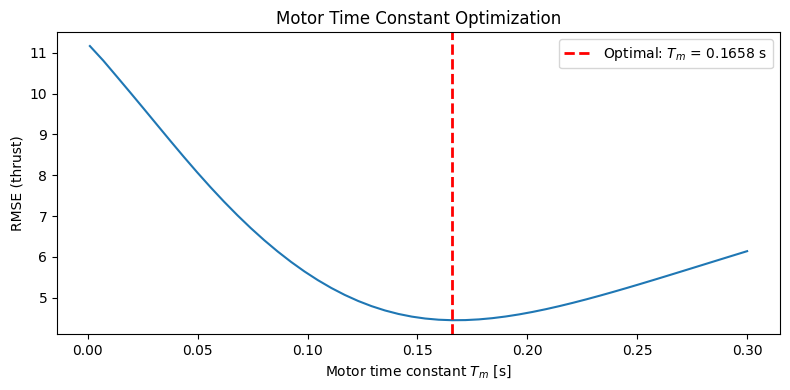

In [62]:
# Select best motor time constant
T_m = T_m_candidates[np.argmin(rmses)]
K_f = K_fs[np.argmin(rmses)]
K_f_mean = K_f.mean(axis=0)

print(f"Optimal motor time constant T_m: {T_m:.4f} s")
print(f"Thrust coefficients: {K_f_mean}")

plt.figure(figsize=(8, 4))
plt.plot(T_m_candidates, rmses)
plt.xlabel("Motor time constant $T_m$ [s]")
plt.ylabel("RMSE (thrust)")
plt.axvline(x=T_m, color='red', linestyle='--', linewidth=2, label=f"Optimal: $T_m$ = {T_m:.4f} s")
plt.legend()
plt.title("Motor Time Constant Optimization")
plt.tight_layout()
plt.savefig(f"figures/{model_name}_motor_time_constant.png", dpi=dpi)
plt.show()

# Recombine with optimal T_m
thrust_curves = np.array([K_f_mean for _ in range(4)])
combined_thrust, flights_thrust_processed = combine(sliced_and_interpolated_flights_thrust, T_m, thrust_curves=thrust_curves)
combined_inertia_roll_pitch, flights_inertia_roll_pitch_processed = combine(sliced_and_interpolated_flights_inertia_roll_pitch, T_m, thrust_curves=thrust_curves)
combined_inertia_yaw, flights_inertia_yaw_processed = combine(sliced_and_interpolated_flights_inertia_yaw, T_m, thrust_curves=thrust_curves)

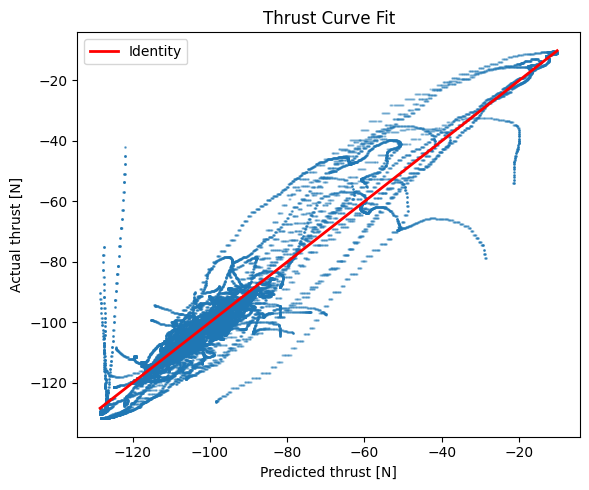

In [63]:
# Plot thrust fit quality
predicted_thrust = combined_thrust["thrusts"].sum(axis=1)
actual_thrust = combined_thrust["acceleration"][:, 2] * model["mass"]

plt.figure(figsize=(6, 5))
plt.scatter(predicted_thrust, actual_thrust, s=0.5, alpha=0.3)
plt.plot([predicted_thrust.min(), predicted_thrust.max()], 
         [predicted_thrust.min(), predicted_thrust.max()], 
         linewidth=2, color="red", label="Identity")
plt.xlabel("Predicted thrust [N]")
plt.ylabel("Actual thrust [N]")
plt.legend()
plt.title("Thrust Curve Fit")
plt.tight_layout()
plt.savefig(f"figures/{model_name}_thrust_fit.png", dpi=dpi)
plt.show()

## Step 6: Estimate Inertia (Roll and Pitch)

I_x (Roll): -1.223754e-03 kg*m^2
I_y (Pitch): 1.995939e-05 kg*m^2


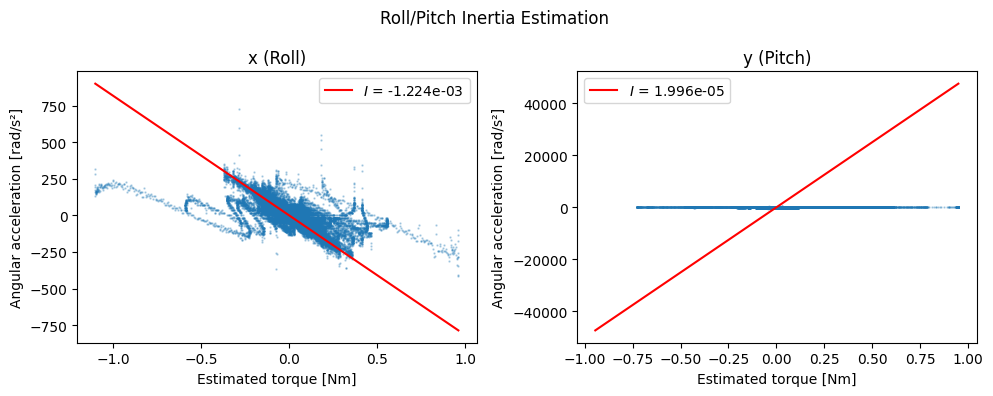

In [64]:
I = []
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for axis_i, axis_name in zip([0, 1], ["x (Roll)", "y (Pitch)"]):
    ax = axs[axis_i]
    dw_full = combined_inertia_roll_pitch["domega"][:, axis_i]
    torque_full = combined_inertia_roll_pitch["pre_torque_geometric"].sum(axis=1)[:, axis_i]
    
    # Filter to use only high-excitation data points
    perc = 50
    dw_perc_lower = np.percentile(dw_full, perc)
    dw_perc_upper = np.percentile(dw_full, 100 - perc)
    mask = (dw_full < dw_perc_lower) | (dw_full > dw_perc_upper)
    
    dw = dw_full[mask]
    torque = torque_full[mask]

    # Estimate inertia using least squares
    I_axis = 1 / (dw**2).sum() * np.inner(dw, torque)
    print(f"I_{axis_name}: {I_axis:.6e} kg*m^2")
    
    ax.scatter(torque, dw, s=0.5, alpha=0.3)
    torques_in = np.linspace(torque_full.min(), torque_full.max(), 100)
    ax.plot(torques_in, torques_in / I_axis, color="red", 
            label=f"$I$ = {I_axis:.3e}")
    ax.set_xlabel(f"Estimated torque [Nm]")
    ax.set_ylabel(f"Angular acceleration [rad/s²]")
    ax.set_title(f"{axis_name}")
    ax.legend()
    I.append(I_axis)

fig.suptitle("Roll/Pitch Inertia Estimation")
fig.tight_layout()
fig.savefig(f"figures/{model_name}_inertia_roll_pitch.png", dpi=dpi)
plt.show()

In [65]:
# Calculate yaw inertia from roll/pitch using ratio
I_xx, I_yy = I[:2]
I_zz = (I_xx + I_yy) / 2 * inertia_ratio
I = [I_xx, I_yy, I_zz]

print(f"I_xx: {I_xx:.6e} kg*m^2")
print(f"I_yy: {I_yy:.6e} kg*m^2") 
print(f"I_zz: {I_zz:.6e} kg*m^2 (estimated using ratio {inertia_ratio})")

I_xx: -1.223754e-03 kg*m^2
I_yy: 1.995939e-05 kg*m^2
I_zz: -1.083415e-03 kg*m^2 (estimated using ratio 1.8)


## Step 7: Estimate Torque Constant (K_tau)

K_tau: -9.798516e-05


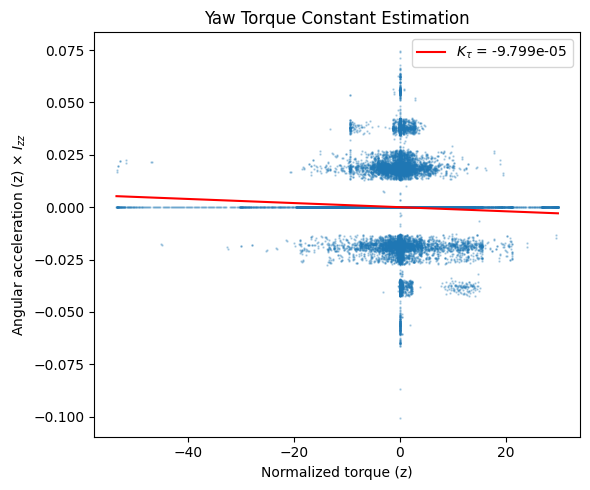

In [66]:
# Estimate yaw torque constant
thrust_torques_inputs = combined_inertia_yaw["thrusts"][:, :, np.newaxis] * model["rotor_torque_directions"]
thrust_torque_inputs_z = thrust_torques_inputs[:, :, 2].sum(axis=1)
dwz = combined_inertia_yaw["domega"][:, 2]

b = dwz * I_zz
K_tau = 1 / (thrust_torque_inputs_z**2).sum() * np.inner(thrust_torque_inputs_z, b)

print(f"K_tau: {K_tau:.6e}")

plt.figure(figsize=(6, 5))
plt.scatter(thrust_torque_inputs_z, b, s=0.5, alpha=0.3)
x_range = np.linspace(thrust_torque_inputs_z.min(), thrust_torque_inputs_z.max(), 100)
plt.plot(x_range, K_tau * x_range, color="red", 
         label=f"$K_\\tau$ = {K_tau:.3e}")
plt.ylabel(f"Angular acceleration (z) × $I_{{zz}}$")
plt.xlabel(f"Normalized torque (z)")
plt.legend()
plt.title("Yaw Torque Constant Estimation")
plt.tight_layout()
plt.savefig(f"figures/{model_name}_K_tau.png", dpi=dpi)
plt.show()

## Step 8: Generate Output JSON

In [67]:
# Build final parameters dictionary
initial_keys = ['mass', 'rotor_positions', 'rotor_thrust_directions', 'rotor_torque_directions']

parameters = {
    **{key: model[key].tolist() if isinstance(model[key], np.ndarray) else model[key] for key in initial_keys},
    "thrust_coefficients": [K_f_mean.tolist()] * 4,
    "rotor_torque_constants": [float(K_tau)] * 4,
    "inertia_diag": [
        float(I_xx),
        float(I_yy),
        float(I_zz)
    ],
    "delay_rising_constants": [float(T_m)] * 4,
    "delay_falling_constants": [float(T_m)] * 4
}

print("System Identification Parameters:")
print("=" * 50)
print(json.dumps(parameters, indent=4))

System Identification Parameters:
{
    "mass": 0.036,
    "rotor_positions": [
        [
            0.019798989873223333,
            -0.01979898987322333,
            0.0
        ],
        [
            -0.019798989873223333,
            -0.01979898987322333,
            0.0
        ],
        [
            -0.019798989873223333,
            0.01979898987322333,
            0.0
        ],
        [
            0.019798989873223333,
            0.01979898987322333,
            0.0
        ]
    ],
    "rotor_thrust_directions": [
        [
            0,
            0,
            1
        ],
        [
            0,
            0,
            1
        ],
        [
            0,
            0,
            1
        ],
        [
            0,
            0,
            1
        ]
    ],
    "rotor_torque_directions": [
        [
            0,
            0,
            -1
        ],
        [
            0,
            0,
            1
        ],
        [
            0,
      

In [68]:
# Save to JSON file
output_file = f"{model_name}_parameters.json"
with open(output_file, 'w') as f:
    json.dump(parameters, f, indent=4)

print(f"\nParameters saved to: {output_file}")


Parameters saved to: my_quad_parameters.json
